In [1]:
pip install tqdm


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\jahed\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [21]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pylab as plt

In [22]:
DATSET = 'dataset_train'
START_TRAIN_IMG_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-3
BATCH_SIZES = [256,256,128,64,32,16]
CHANNELS_IMG = 3
Z_DIM = 512
W_DIM = 512
IN_CHANNELS = 512
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = [10] * len(BATCH_SIZES)

In [23]:
def get_loader(image_size):
    trainsform = transforms.Compose(
        [transforms.Resize((image_size, image_size)),
         transforms.ToTensor(),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)],
            [0.5 for _ in range(CHANNELS_IMG)],
         )
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size/4))]
    dataset = datasets.ImageFolder(root=DATSET, transform=trainsform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )
    return loader, dataset

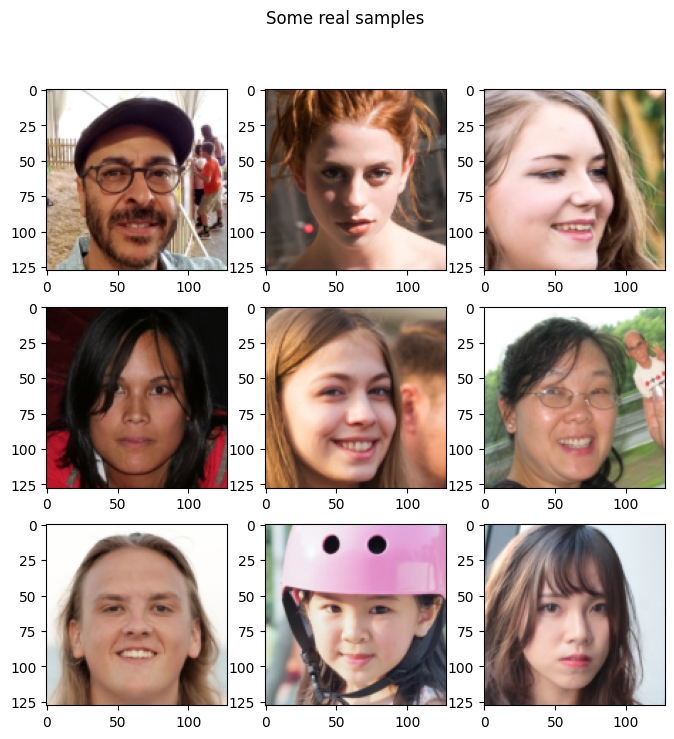

In [24]:
def check_loader():
    loader,_ = get_loader(128)
    face,_  = next(iter(loader))
    _,ax     = plt.subplots(3,3,figsize=(8,8))
    plt.suptitle('Some real samples')
    ind = 0
    for k in range(3):
        for kk in range(3):
            ax[k][kk].imshow((face[ind].permute(1,2,0)+1)/2)
            ind +=1
check_loader() 

In [6]:
factors = [1,1,1,1/2,1/4,1/8,1/16,1/32]

In [7]:
class WSLinear(nn.Module):
    def __init__(
        self, in_features, out_features
    ):
        super(WSLinear,self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.scale  = (2/in_features) ** 0.5
        self.bias   = self.linear.bias
        self.linear.bias = None

        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)

    def forward(self,x):
        return self.linear(x * self.scale) + self.bias

In [8]:
class PixenNorm(nn.Module):
    def __init__(self):
        super(PixenNorm, self).__init__()
        self.epsilon = 1e-8
    def forward(self,x ):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True)+  self.epsilon)

In [9]:
class MappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            PixenNorm(),
            WSLinear(z_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )
    
    def forward(self,x):
        return self.mapping(x)

In [10]:
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale   = WSLinear(w_dim, channels)
        self.style_bias    = WSLinear(w_dim, channels)

    def forward(self,x,w):
        x = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias  = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * x + style_bias

In [11]:
class injectNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1,channels,1,1))

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device = x.device)
        return x + self.weight + noise

In [12]:
class GenBlock(nn.Module):
    def __init__(self, in_channel, out_channel, w_dim):
        super(GenBlock, self).__init__()
        self.conv1 = WSConv2d(in_channel, out_channel)
        self.conv2 = WSConv2d(out_channel, out_channel)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.inject_noise1 = injectNoise(out_channel)
        self.inject_noise2 = injectNoise(out_channel)
        self.adain1 = AdaIN(out_channel, w_dim)
        self.adain2 = AdaIN(out_channel, w_dim)
    def forward(self, x,w):
        x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
        x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
        return x

In [13]:
class Generator(nn.Module):
    def __init__(self, z_dim, w_dim, in_channels, img_channels=3):
        super().__init__()
        self.starting_cte = nn.Parameter(torch.ones(1, in_channels, 4,4))
        self.map = MappingNetwork(z_dim, w_dim)
        self.initial_adain1 = AdaIN(in_channels, w_dim)
        self.initial_adain2 = AdaIN(in_channels, w_dim)
        self.initial_noise1 = injectNoise(in_channels)
        self.initial_noise2 = injectNoise(in_channels)
        self.initial_conv   = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.leaky          = nn.LeakyReLU(0.2, inplace=True)

        self.initial_rgb    = WSConv2d(
            in_channels, img_channels, kernel_size = 1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb])
        )

        for i in range(len(factors)-1):
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i+1])
            self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
            self.rgb_layers.append(WSConv2d(conv_out_c, img_channels, kernel_size = 1, stride=1, padding=0))
        
    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1-alpha ) * upscaled)

    def forward(self, noise, alpha, steps):
        w = self.map(noise)
        x = self.initial_adain1(self.initial_noise1(self.starting_cte),w)
        x = self.initial_conv(x)
        out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)

        if steps == 0:
            return self.initial_rgb(x)
        
        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode = 'bilinear')
            out      = self.prog_blocks[step](upscaled,w)

        final_upscaled = self.rgb_layers[steps-1](upscaled)
        final_out      = self.rgb_layers[steps](out)

        return self.fade_in(alpha, final_upscaled, final_out)

In [14]:
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        return x

In [16]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [17]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()

In [18]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [19]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen
):
    loop = tqdm(loader, leave=True)

    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        noise = torch.randn(cur_batch_size, Z_DIM).to(DEVICE)
        fake  = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001) * torch.mean(critic_real ** 2)
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        alpha += cur_batch_size / (
            PROGRESSIVE_EPOCHS[step] * 0.5 * len(dataset)
        )
        alpha = min(alpha,1)


        loop.set_postfix(
            gp = gp.item(),
            loss_critic = loss_critic.item()
        )
    return alpha

In [20]:
gen = Generator(
    Z_DIM, W_DIM, IN_CHANNELS, CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
opt_gen = optim.Adam([{'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
                     {'params': gen.map.parameters(), 'lr': 1e-5}], lr=LR, betas =(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr= LR, betas =(0.0, 0.99)
)

gen.train()
critic.train()
step = int(log2(START_TRAIN_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-7
    loader, dataset = get_loader(4*2**step)
    print('Curent image size: '+str(4*2**step))

    for epoch in range(num_epochs):
        print(f'Epoch [{epoch + 1}/ {num_epochs}')
        alpha = train_fn(
            critic, gen, loader, dataset, step, alpha, opt_critic, opt_gen
        )
    generate_examples(gen, step)
    step +=1

Curent image size: 4
Epoch [1/ 10


100%|██████████| 4/4 [00:26<00:00,  6.64s/it, gp=0.00799, loss_critic=-65.3]


Epoch [2/ 10


100%|██████████| 4/4 [00:25<00:00,  6.50s/it, gp=0.131, loss_critic=-217] 


Epoch [3/ 10


100%|██████████| 4/4 [00:25<00:00,  6.50s/it, gp=0.257, loss_critic=-388]


Epoch [4/ 10


100%|██████████| 4/4 [00:25<00:00,  6.40s/it, gp=0.464, loss_critic=-163]


Epoch [5/ 10


100%|██████████| 4/4 [00:25<00:00,  6.45s/it, gp=1.83, loss_critic=-415] 


Epoch [6/ 10


100%|██████████| 4/4 [00:25<00:00,  6.45s/it, gp=2.94, loss_critic=-361]


Epoch [7/ 10


100%|██████████| 4/4 [00:25<00:00,  6.40s/it, gp=3.63, loss_critic=-427]


Epoch [8/ 10


100%|██████████| 4/4 [00:25<00:00,  6.40s/it, gp=4.9, loss_critic=-266] 


Epoch [9/ 10


100%|██████████| 4/4 [00:25<00:00,  6.44s/it, gp=3.68, loss_critic=-155]


Epoch [10/ 10


100%|██████████| 4/4 [00:25<00:00,  6.30s/it, gp=5.4, loss_critic=-295] 


Curent image size: 8
Epoch [1/ 10


100%|██████████| 4/4 [00:27<00:00,  6.76s/it, gp=0.185, loss_critic=-4.54]


Epoch [2/ 10


100%|██████████| 4/4 [00:27<00:00,  6.90s/it, gp=0.0508, loss_critic=-4.22]


Epoch [3/ 10


100%|██████████| 4/4 [00:27<00:00,  6.80s/it, gp=0.0805, loss_critic=-6.85]


Epoch [4/ 10


100%|██████████| 4/4 [00:26<00:00,  6.59s/it, gp=0.156, loss_critic=-8.09]


Epoch [5/ 10


100%|██████████| 4/4 [00:26<00:00,  6.60s/it, gp=0.165, loss_critic=-7.71]


Epoch [6/ 10


100%|██████████| 4/4 [00:26<00:00,  6.70s/it, gp=0.171, loss_critic=-7.46]


Epoch [7/ 10


100%|██████████| 4/4 [00:27<00:00,  6.90s/it, gp=0.199, loss_critic=-7.83]


Epoch [8/ 10


100%|██████████| 4/4 [00:27<00:00,  6.85s/it, gp=0.175, loss_critic=-7.67]


Epoch [9/ 10


100%|██████████| 4/4 [00:27<00:00,  6.86s/it, gp=0.195, loss_critic=-7.58]


Epoch [10/ 10


100%|██████████| 4/4 [00:26<00:00,  6.69s/it, gp=0.154, loss_critic=-7.75]


Curent image size: 16
Epoch [1/ 10


100%|██████████| 8/8 [00:30<00:00,  3.87s/it, gp=0.258, loss_critic=-12.6]  


Epoch [2/ 10


100%|██████████| 8/8 [00:30<00:00,  3.85s/it, gp=0.258, loss_critic=-12.5]


Epoch [3/ 10


100%|██████████| 8/8 [00:30<00:00,  3.84s/it, gp=0.153, loss_critic=-14.8]


Epoch [4/ 10


100%|██████████| 8/8 [00:30<00:00,  3.86s/it, gp=0.232, loss_critic=-14.7]


Epoch [5/ 10


100%|██████████| 8/8 [00:31<00:00,  3.92s/it, gp=0.163, loss_critic=-15.2]


Epoch [6/ 10


100%|██████████| 8/8 [00:31<00:00,  3.95s/it, gp=0.425, loss_critic=-14.7]


Epoch [7/ 10


100%|██████████| 8/8 [00:30<00:00,  3.84s/it, gp=0.59, loss_critic=-15.2] 


Epoch [8/ 10


100%|██████████| 8/8 [00:31<00:00,  3.88s/it, gp=0.528, loss_critic=-15.3] 


Epoch [9/ 10


100%|██████████| 8/8 [00:30<00:00,  3.83s/it, gp=0.134, loss_critic=-14]  


Epoch [10/ 10


100%|██████████| 8/8 [00:30<00:00,  3.84s/it, gp=0.22, loss_critic=-14.4] 


Curent image size: 32
Epoch [1/ 10


100%|██████████| 16/16 [00:38<00:00,  2.42s/it, gp=0.801, loss_critic=-31.2]


Epoch [2/ 10


100%|██████████| 16/16 [00:38<00:00,  2.41s/it, gp=0.958, loss_critic=-26.9] 


Epoch [3/ 10


100%|██████████| 16/16 [00:38<00:00,  2.41s/it, gp=1.27, loss_critic=-28.7] 


Epoch [4/ 10


100%|██████████| 16/16 [00:39<00:00,  2.44s/it, gp=0.184, loss_critic=-26.8]


Epoch [5/ 10


100%|██████████| 16/16 [00:40<00:00,  2.51s/it, gp=1.08, loss_critic=-24.2]  


Epoch [6/ 10


100%|██████████| 16/16 [00:38<00:00,  2.43s/it, gp=0.148, loss_critic=-24.4]


Epoch [7/ 10


100%|██████████| 16/16 [00:38<00:00,  2.40s/it, gp=0.457, loss_critic=-19.4]


Epoch [8/ 10


100%|██████████| 16/16 [00:38<00:00,  2.40s/it, gp=0.0946, loss_critic=-20.4]


Epoch [9/ 10


100%|██████████| 16/16 [00:38<00:00,  2.40s/it, gp=0.572, loss_critic=-21.9]


Epoch [10/ 10


100%|██████████| 16/16 [00:38<00:00,  2.40s/it, gp=1.04, loss_critic=-24.3] 


Curent image size: 64
Epoch [1/ 10


100%|██████████| 32/32 [00:51<00:00,  1.60s/it, gp=3.17, loss_critic=-24.9] 


Epoch [2/ 10


100%|██████████| 32/32 [00:52<00:00,  1.63s/it, gp=1.5, loss_critic=-24.2]  


Epoch [3/ 10


100%|██████████| 32/32 [00:52<00:00,  1.64s/it, gp=0.669, loss_critic=-53.8]


Epoch [4/ 10


100%|██████████| 32/32 [00:51<00:00,  1.62s/it, gp=2.8, loss_critic=-39.3]   


Epoch [5/ 10


100%|██████████| 32/32 [00:51<00:00,  1.60s/it, gp=2.72, loss_critic=-82.4]  


Epoch [6/ 10


100%|██████████| 32/32 [00:51<00:00,  1.61s/it, gp=1.17, loss_critic=-42.3] 


Epoch [7/ 10


100%|██████████| 32/32 [00:51<00:00,  1.60s/it, gp=0.551, loss_critic=-29.5]


Epoch [8/ 10


100%|██████████| 32/32 [00:51<00:00,  1.60s/it, gp=0.567, loss_critic=-50.9]


Epoch [9/ 10


100%|██████████| 32/32 [00:51<00:00,  1.62s/it, gp=0.612, loss_critic=-28.6]


Epoch [10/ 10


100%|██████████| 32/32 [00:52<00:00,  1.63s/it, gp=2.39, loss_critic=-55.7] 


Curent image size: 128
Epoch [1/ 10


100%|██████████| 63/63 [01:15<00:00,  1.19s/it, gp=4.63, loss_critic=-69]   


Epoch [2/ 10


100%|██████████| 63/63 [01:15<00:00,  1.20s/it, gp=2.69, loss_critic=-88.4] 


Epoch [3/ 10


100%|██████████| 63/63 [01:16<00:00,  1.21s/it, gp=2.39, loss_critic=-105]  


Epoch [4/ 10


100%|██████████| 63/63 [01:15<00:00,  1.20s/it, gp=9.59, loss_critic=-64.8] 


Epoch [5/ 10


100%|██████████| 63/63 [01:15<00:00,  1.20s/it, gp=12.6, loss_critic=-137]    


Epoch [6/ 10


100%|██████████| 63/63 [01:16<00:00,  1.21s/it, gp=4.5, loss_critic=-137]   


Epoch [7/ 10


100%|██████████| 63/63 [01:16<00:00,  1.21s/it, gp=5.85, loss_critic=-109]  


Epoch [8/ 10


100%|██████████| 63/63 [48:19<00:00, 46.02s/it, gp=5.01, loss_critic=-91.7]    


Epoch [9/ 10


100%|██████████| 63/63 [01:14<00:00,  1.18s/it, gp=3.78, loss_critic=-103]  


Epoch [10/ 10


100%|██████████| 63/63 [01:15<00:00,  1.20s/it, gp=2.46, loss_critic=-93.8] 


In [34]:
from torchvision.utils import save_image
import os
import torch

def generate_images(generator, step, num_images=16, save_dir="generated_images"):
    """
    Generate and save images from the trained generator.

    Args:
        generator (nn.Module): The trained generator model.
        step (int): The current resolution step (log2 of resolution divided by 2).
        num_images (int): Number of images to generate.
        save_dir (str): Directory to save the generated images.
    """
    os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist

    generator.eval()  # Set generator to evaluation mode

    # Calculate the resolution (e.g., 4, 8, 16, etc.)
    resolution = 4 * (2 ** step)
    alpha = 1.0  # Fully grown images (no fading)

    # Generate random latent vectors z
    z = torch.randn(num_images, Z_DIM).to(DEVICE)

    # Generate images
    with torch.no_grad():  # No gradient calculation
        generated_images = generator(z, alpha, step)

    # Denormalize images from [-1, 1] to [0, 1]
    generated_images = (generated_images + 1) / 2

    # Save images
    for i in range(num_images):
        save_image(
            generated_images[i],
            os.path.join(save_dir, f"generated_step{step}_img{i+1}.png")
        )
    print(f"{num_images} images saved to {save_dir}.")


In [39]:
generate_images(gen, 5, num_images=16, save_dir="generated_images")

16 images saved to generated_images.
